# `YData Synthetic` and `Data Profiler`: Streamlined data synthesis and profiling
This notebook shows you how to integrate the [Data Profiler](https://github.com/capitalone/DataProfiler) package on a `YData Synthetic` project. By combining these two packages you can easily synthesize data and profile it to assess the quality of the generated data.

The demo will take the following steps:
1. Install `DataProfiler` and import required packages
2. Read a dataset
3. Profile the dataset
4. Define and fit a synthesizer
5. Sample and profile synthetic data
6. Compare sample profiles with `Profiler`'s `diff` method
7. Compare marginal distributions with the `Graph` module
8. Saving/loading a profile for later analysis
9. Conclusion

Let's get started!

## 1. Install `DataProfiler` and import required packages
`DataProfiler` is a package that helps you doing data analysis with a focus on profiling and sensitive data detection.
We will use the slimmer version and leverage `Profiler` reports and graphical utilities.

To install the package we just need to uncomment and run the following cell:

In [1]:
#!pip install DataProfiler[reports]

Now we import all the required packages for this notebook.

In [2]:
from pprint import pprint
import matplotlib.pyplot as plt

from pandas import read_csv
from ydata_synthetic.synthesizers.regular import WGAN_GP
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from dataprofiler import Profiler, graphs

If you are using GPU you might need to allow memory growth:

In [3]:
from tensorflow import config
physical_devices = config.list_physical_devices('GPU') 
for device in physical_devices:
    config.experimental.set_memory_growth(device, True)

## 2. Read a dataset
The dataset that we will use in this demo is sampled from the popular [cardio](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

We produced this sample by cleaning out some outliers that are extremely unlikely or even physically impossible by enforcing the following conditions:
* Diastolic (lower) pressure must be bigger than 0
* Systolic pressure (higher) must not be bigger than 240 (above [hypertensive crisis](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings))
* Diastolic pressure must be lower than the systolic blood pressure values

By applying these criteria we filtered out roughly 1.9% of the records and made the sample much more representative of a real population.

In [4]:
data = read_csv('../../data/cardio_sample.csv')
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 3. Profile the dataset
The `Profiler` is the main class that unlocks further data analysis.

Depending on the passed data object either an `UnstructuredProfiler`, specialized for text data, or a `StructuredProfiler`, specialized for tabular data, will be automatically dispatched.

In [5]:
profile = Profiler(data)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 11 processes)


/home/fsantos/miniconda3/envs/ydata_synth/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:2021: UserWarning: The data will be profiled with a sample size of 13734. All statistics will be based on this subsample and not the whole dataset.
  warnings.warn("The data will be profiled with a sample size of {}. "
100%|██████████| 12/12 [00:00<00:00, 136.50it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████| 12/12 [00:02<00:00,  4.77it/s]


The `report` method of the `Profiler` allows you to easily get inferred information and statistics in a global (dataset) and data specific (column/row) level.

In [6]:
base_report = profile.report(report_options={'output_format': 'compact'})
pprint(base_report['global_stats'])

{'chi2_matrix': '[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '
                'nan], ... , [nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  '
                '0.,  0.,  1.]]',
 'column_count': 12,
 'correlation_matrix': None,
 'duplicate_row_count': 24,
 'encoding': None,
 'file_type': "<class 'pandas.core.frame.DataFrame'>",
 'profile_schema': defaultdict(<class 'list'>,
                               {'active': [10],
                                'age': [0],
                                'alco': [9],
                                'ap_hi': [4],
                                'ap_lo': [5],
                                'cardio': [11],
                                'cholesterol': [6],
                                'gender': [1],
                                'gluc': [7],
                                'height': [2],
                                'smoke': [8],
                                'weight': [3]}),
 'row_count': 68671,
 'row_has_null_ratio': 0.0,
 

In [7]:
pprint(base_report['data_stats'])

[{'categorical': False,
  'column_name': 'age',
  'data_label': 'INTEGER',
  'data_type': 'int',
  'order': 'random',
  'samples': "['16170', '19705', '23396', '23407', '21675']",
  'statistics': {'data_type_representation': {'datetime': 0.0,
                                              'float': 1.0,
                                              'int': 1.0,
                                              'string': 1.0},
                 'kurtosis': -0.8354,
                 'max': 23667.0,
                 'mean': 19436.1721,
                 'median': 19676.1589,
                 'median_abs_deviation': 1726.0276,
                 'min': 10878.0,
                 'mode': '[20361.0435]',
                 'null_count': 0,
                 'null_types': '[]',
                 'num_negatives': 0,
                 'num_zeros': 0,
                 'quantiles': {0: 17609.1247, 1: 19676.1589, 2: 21307.9937},
                 'sample_size': 13734,
                 'skewness': -0.2881,
         

## 4. Define and fit a synthesizer
From the `YData Synthetic` library we will define a Wasserstein GAN with Gradient Penalty, `WGAN_GP`, to generate synthetic data:

In [8]:
# Define Model Parameters
batch_size = 500
learning_rate = [5e-4, 3e-3]
beta_1 = 0.5
beta_2 = 0.9
noise_dim = 128
dim = 128
tau=1e-5

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           betas=(beta_1, beta_2),
                           noise_dim=noise_dim,
                           layers_dim=dim,
                           tau_gs=tau)

# Define Train Parameters
log_step = 100
epochs = 200

train_args = TrainParameters(epochs=epochs,
                             sample_interval=log_step)

# Define data types
num_cols = list(data.columns[data.nunique()>=5])
cat_cols = list(data.columns[data.nunique()<5])

# Instantiate synthesizer
synthesizer = WGAN_GP(gan_args, n_critic=5)

And we fit the synthesizer by running the `train` method.

In [ ]:
synthesizer.train(data, train_args, num_cols, cat_cols)

## 5. Sample and profile synthetic data
With the fitted synthesizer we can obtain synthetic samples by leveraging the `sample` method.

In [10]:
synth_data = synthesizer.sample(len(data)).iloc[:len(data)]

Synthetic data generation: 100%|██████████| 138/138 [00:00<00:00, 157.06it/s]


As simple as for the real data we can create a `Profiler` with our new sample.

In [11]:
synth_profile = Profiler(synth_data)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 11 processes)


/home/fsantos/miniconda3/envs/ydata_synth/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:2021: UserWarning: The data will be profiled with a sample size of 13734. All statistics will be based on this subsample and not the whole dataset.
  warnings.warn("The data will be profiled with a sample size of {}. "
100%|██████████| 12/12 [00:00<00:00, 130.71it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


  8%|▊         | 1/12 [00:00<00:01,  7.60it/s]

 25%|██▌       | 3/12 [00:00<00:00,  9.94it/s]

100%|██████████| 12/12 [00:01<00:00, 11.26it/s]


## 6. Compare sample profiles with `Profiler`'s `diff` method
The `diff` method of the `Profiler` allows us to obtain a description of the differences between two data profiles, as long as they share the same schema. This allows us to get a glimpse of the similarities between two samples, a useful way to compare synthetic samples with the real data!

In [12]:
synth_diff_report = profile.diff(synth_profile)

In [13]:
pprint(synth_diff_report['global_stats'])

{'chi2_matrix': array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  0.00000000e+00,  0.00000000e+00,
                    nan,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [            nan,  0.00000000e+00,  0.00000000e+00,
                    nan,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  0.00000000

In [14]:
pprint(synth_diff_report['data_stats'])

[{'categorical': 'unchanged',
  'column_name': 'age',
  'data_label': 'unchanged',
  'data_type': 'unchanged',
  'order': 'unchanged',
  'statistics': {'avg_predictions': {'ADDRESS': 0.009199999999999984,
                                     'BAN': 'unchanged',
                                     'CREDIT_CARD': 'unchanged',
                                     'DATE': 'unchanged',
                                     'DATETIME': 'unchanged',
                                     'DRIVERS_LICENSE': 'unchanged',
                                     'EMAIL_ADDRESS': 'unchanged',
                                     'FLOAT': 'unchanged',
                                     'HASH_OR_KEY': 'unchanged',
                                     'INTEGER': -0.0030000000000001137,
                                     'IPV4': 'unchanged',
                                     'IPV6': 'unchanged',
                                     'MAC_ADDRESS': 'unchanged',
                                     'OR

## 7. Compare marginal distributions with the `Graph` module
The `Graph` module contains some plotting functions that can be used in detecting missing values with `plot_missing_values_matrix` or comparing marginal distributions with `plot_histograms` method. The latter is another useful way of validating the quality of synthetic samples.

These methods return `matplotlib` figures which also allows you to do some further customization.

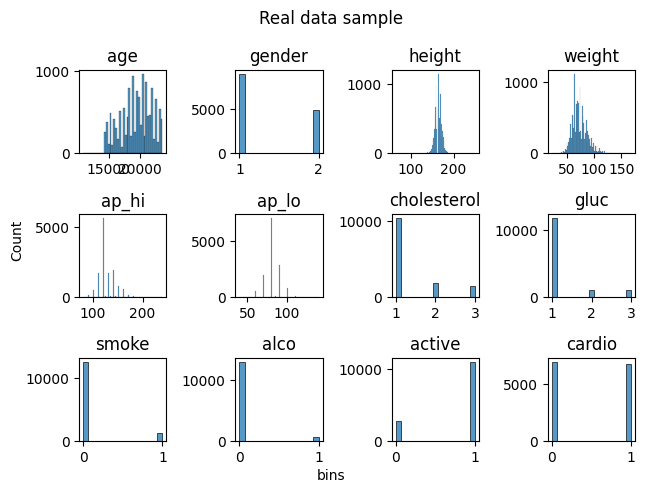

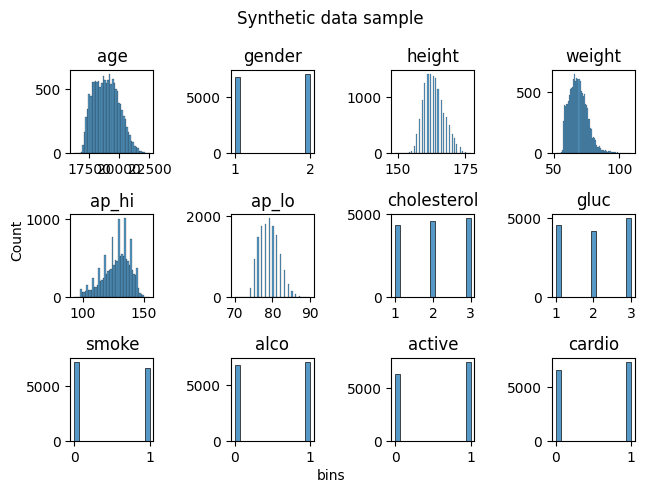

In [15]:
real_fig = graphs.plot_histograms(profile)
real_fig.suptitle('Real data sample')
real_fig.tight_layout()

synth_fig = graphs.plot_histograms(synth_profile)
synth_fig.suptitle('Synthetic data sample')
synth_fig.tight_layout()

plt.show()

## 8. Saving/loading a profile for later analysis
`DataProfiler` also allows saving and loading profiles. This is another a useful feature for your `YData Synthetic` projects. To save a profile you can use the `Profiler`'s `save` method.

As an example, we can save the synthesizer and the synthetic data sample profile that we have just created and worry about sample evaluation or model selection after a batch of experiments.

In [16]:
synth_profile.save(filepath='synthetic_data_profile.pkl')
synthesizer.save(path='synthesizer.pkl')

Reloading data profiles with the `load` method is easy as well:

In [17]:
synth_profile = Profiler.load(filepath='synthetic_data_profile.pkl')

## 9. Conclusion
`DataProfiler` has a set of tools that are good additions to your Machine Learning flows.

We hope this notebook has demonstrated the capacities of the `DataProfiler` package and how you can use it in the context of a `YData Synthetic` project. 